In [11]:
import pandas as pd
import numpy as np
from utils.design_matrix_creator import get_design_matricies

# Load the CSV file
data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

# Select columns for the coverage timeline
coverage_data = data.filter(regex='^CoverageTimeline_T')

# Calculate the integral for each row using the trapezoidal rule
data['IntegralValue'] = coverage_data.apply(lambda row: np.trapz(row, dx=1), axis=1)
#data['IntegralValue'] = data['IntegralValue'] / 300.0
            
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'IntegralValue')

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


In [2]:
import pymc as pm
with pm.Model():
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=150, sigma=30)
    
    # Standard Deviations for modules, parameters and nteractions
    sigma_a = pm.Exponential('sigma_a', 0.03)
    sigma_b = pm.Exponential('sigma_b', 0.1)
    sigma_g = pm.Exponential('sigma_g', 0.1)
    
    # Non-centered parameterizations for module, parameter and interaction effect.
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct dummy variables
    identity_a = pm.math.dot(module_matrix, a_m)
    identity_b = pm.math.dot(parameter_matrix, b_p)
    identity_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (identity)
    mu = pm.Deterministic('mu', identity_a + identity_b + identity_g)
    
    # Normal distribution likelihood 
    sigma = pm.Exponential('sigma', 0.1)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=observation_matrix['IntegralValue'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, sigma_b, a_offset, b_offset, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2488 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [3]:
import arviz as az

az.to_netcdf(trace, "coverage_rate_single_parameter_2.nc")

'coverage_rate_single_parameter_2.nc'

In [6]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp


# Example usage
trace = az.from_netcdf("coverage_rate_single_parameter_2.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'sigma', 'sigma_b', 'b_p']
transformations = {
    #'a_m': log_to_exp,
    #'a_bar': log_to_exp,
    #'sigma_a': log_to_exp
    #'b_p': log_to_exp
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
table = az.summary(idata, ['a_m', 'a_bar', 'sigma_a', 'sigma', 'sigma_b', 'b_p'], hdi_prob=0.89)
table

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],258.802,0.675,257.730,259.881,0.011,0.008,3834.0,3510.0,1.00
a_m[1],199.348,0.673,198.349,200.476,0.011,0.008,3927.0,2964.0,1.00
a_m[2],276.039,0.677,274.895,277.053,0.011,0.008,3773.0,2884.0,1.00
a_m[3],13.718,0.690,12.589,14.793,0.011,0.008,4058.0,3420.0,1.00
a_m[4],19.980,0.689,18.901,21.079,0.011,0.008,4126.0,3448.0,1.00
a_m[5],179.437,0.662,178.343,180.465,0.011,0.008,3824.0,2853.0,1.00
a_m[6],221.404,0.690,220.376,222.585,0.011,0.008,3755.0,2642.0,1.00
a_m[7],239.227,0.691,238.183,240.385,0.011,0.008,4025.0,3048.0,1.00
a_m[8],65.409,0.699,64.329,66.526,0.011,0.008,4059.0,3028.0,1.00
a_m[9],37.968,0.691,36.832,39.020,0.011,0.008,3723.0,3550.0,1.00


array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>]],
      dtype=object)

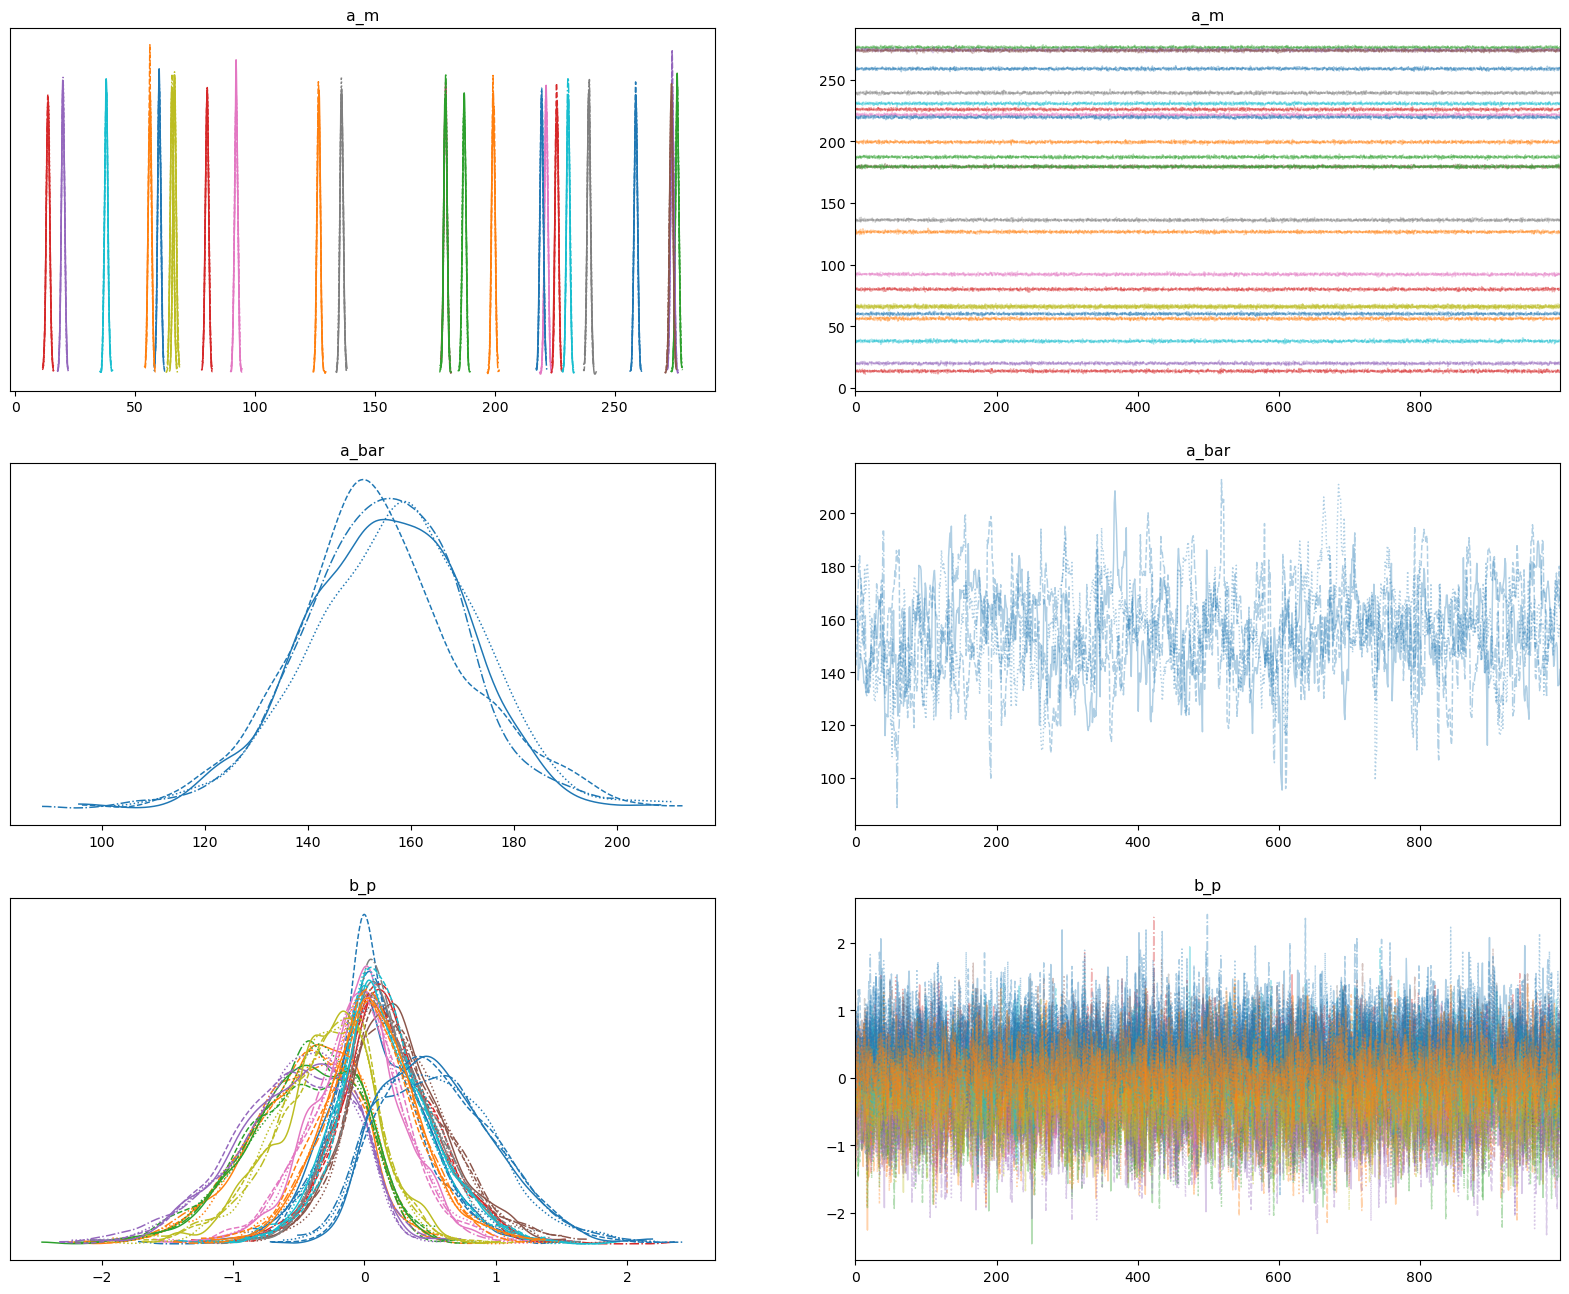

In [5]:
az.plot_trace(idata, var_names=['a_m', 'a_bar', 'b_p'], figsize=(20, 16))

In [8]:
import arviz as az
az.compare({"model_1": az.from_netcdf("coverage_rate_single_parameter.nc"), 
            "model_2": az.from_netcdf("coverage_rate_single_parameter_2.nc")}, ic="loo")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_1,0,-37536.363377,42.302848,0.000000,1.0,235.244361,0.00000,False,log
model_2,1,-37536.382990,42.387618,0.019613,0.0,235.210445,0.16171,False,log


In [9]:
az.loo(az.from_netcdf("coverage_rate_single_parameter.nc"))

Computed from 4000 posterior samples and 9360 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -37536.36   235.24
p_loo       42.30        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9360  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [10]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import truncnorm
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma, e):
    with pm.Model():
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Non-centered parameterizations
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (logit), unbounded to (0,1) probability
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', a_m + b_p + g_mp)
        
        # Beta distribution likelihood 
        pm.Exponential('sigma', e)#pm.Uniform('theta', 5, 100)
        
        # Sample from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_sigma = idata.prior['sigma'].values.flatten()

    #a = (0 - prior_mu) / prior_sigma
    #b = (300 - prior_mu) / prior_sigma


    simulated_observations = np.random.normal(loc=prior_mu, scale=prior_sigma)
    
    #Predicated observations
    plt.figure(figsize=(4, 3))

    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Algorithm Iterations using priors ', 'Values',
                                     'darkcyan', bin_range=(-50,350))
    observation_plot.plot()


    plots = [
        HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior Distribution of mu (before) - Identity', 'mu', 'black'),
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior Distribution of mu - Identity', 'mu', 'purple', bin_range=(0, 300)),
        HistogramPlot(idata.prior['sigma'].values.flatten(), 'Prior Distribution of sigma - Exponential', 'sigma', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of a_bar - Normal(0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior Distribution of a_m - Normal(a_bar, sigma)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))


s_a = FloatSlider(value=0.05, min=0, max=1, step=0.001, description='Sigma_alpha (sigma_a):')
s_b = FloatSlider(value=0.1, min=0, max=1, step=0.05, description='Sigma_beta (sigma_b):')
s_g = FloatSlider(value=0.1, min=0, max=1, step=0.05, description='Sigma_gamma (sigma_g):')
a_bar_mu = FloatSlider(value=150, min=0, max=300, step=0.1, description='alpha bar mu (a_bar_mu):')
a_bar_sigma = FloatSlider(value=30, min=0, max=300, step=0.1, description='alpha bar sigma (a_bar_sigma):')
exp_value = FloatSlider(value=0.1, min=0, max=2, step=0.05, description='exponential value (exp_value):')



interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma,e=exp_value)
#calc_prior_dist(4,4,4,7,0.5)

interactive(children=(FloatSlider(value=0.05, description='Sigma_alpha (sigma_a):', max=1.0, step=0.001), Floa…

<function __main__.calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma, e)>

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


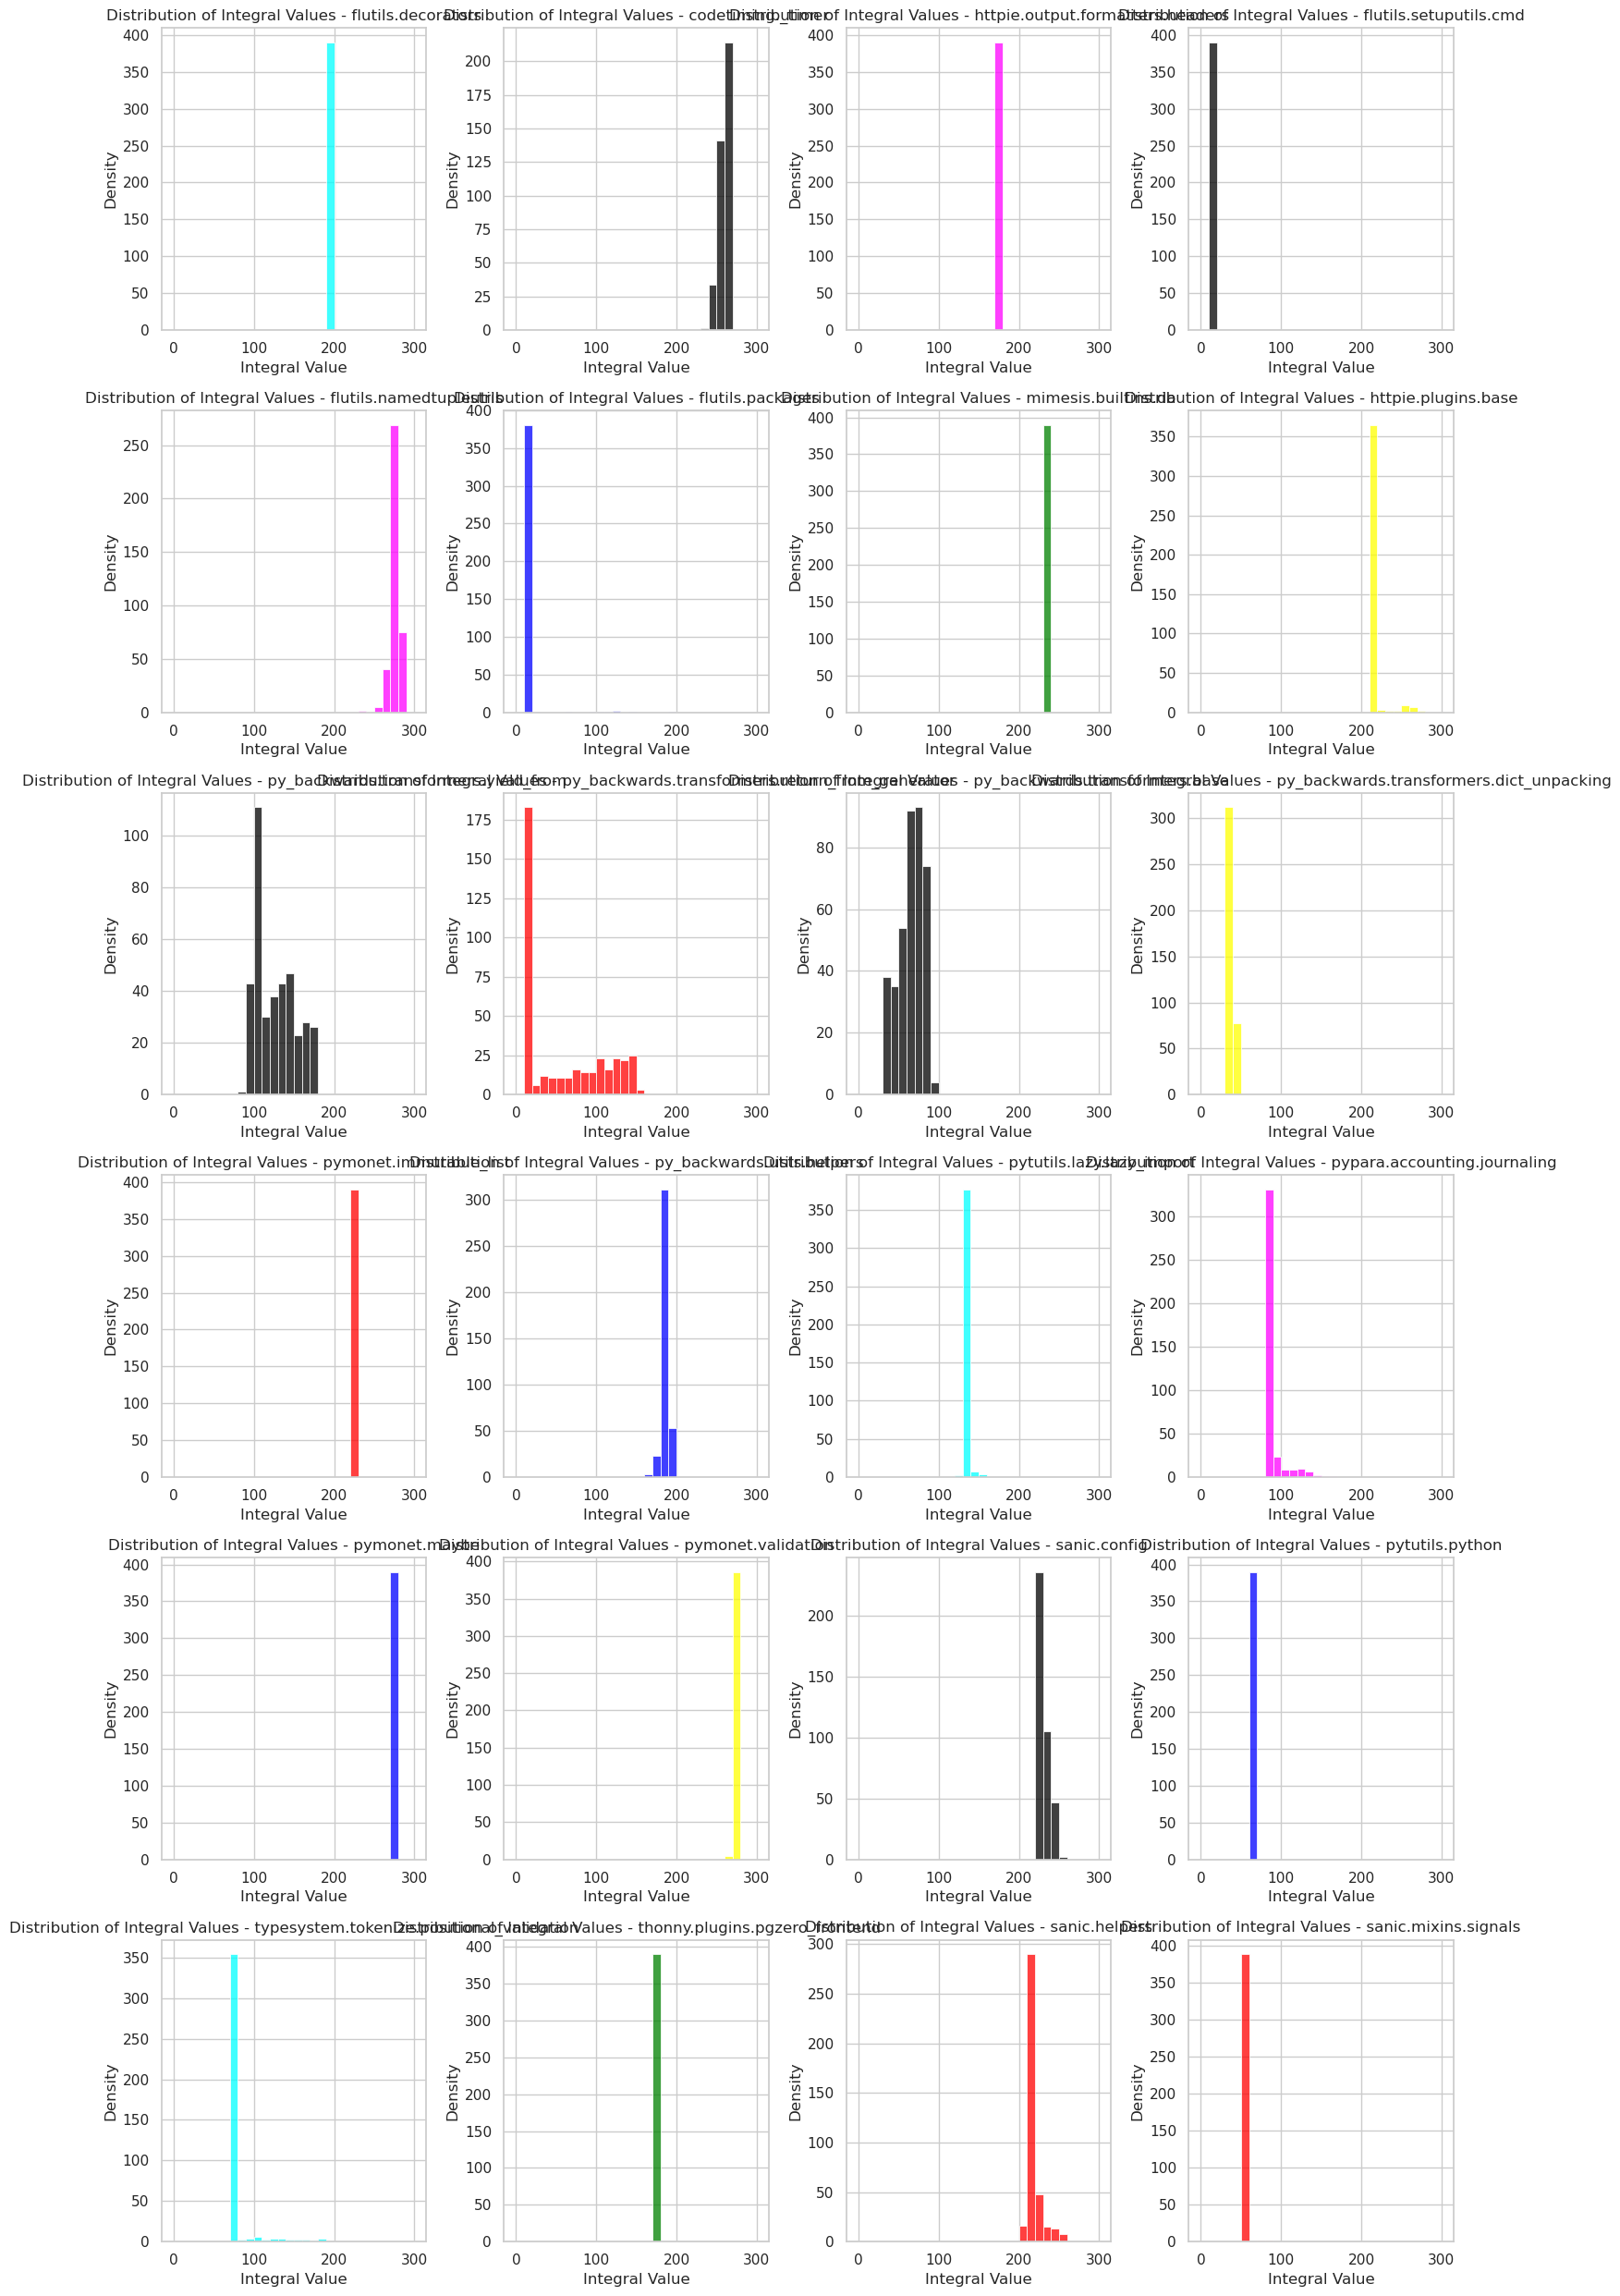

In [12]:
from utils.prior_check_helper import HistogramPlot, plot_histograms
from utils.design_matrix_creator import get_design_matricies
import pandas as pd
import numpy as np

# Load the CSV file
data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

# Select columns for the coverage timeline
coverage_data = data.filter(regex='^CoverageTimeline_T')

# Calculate the integral for each row using the trapezoidal rule
data['IntegralValue'] = coverage_data.apply(lambda row: np.trapz(row, dx=1), axis=1)

observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'IntegralValue')

# Assuming you have a column 'TargetModule' that categorizes data and 'IntegralValue' as the value column
unique_modules = data['TargetModule'].unique()
histogram_plots = []

# Generate a HistogramPlot object for each unique module
for module in unique_modules:
    module_data = data[data['TargetModule'] == module]['IntegralValue']
    if not module_data.empty:
        title = f'Distribution of Integral Values - {module}'
        xlabel = 'Integral Value'
        color = np.random.choice(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
        plot = HistogramPlot(module_data, title, xlabel, color, bin_range=(0,300), bins=30)
        histogram_plots.append(plot)

# Now use the function to plot all histograms
plot_histograms(histogram_plots, nrows=6, ncols=4, figsize=(15, 25))




Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


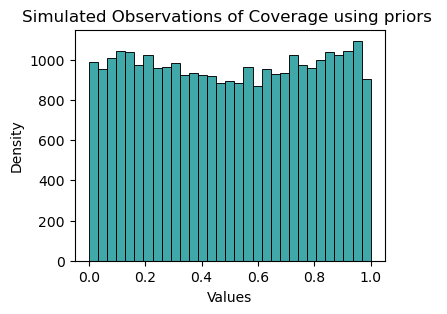

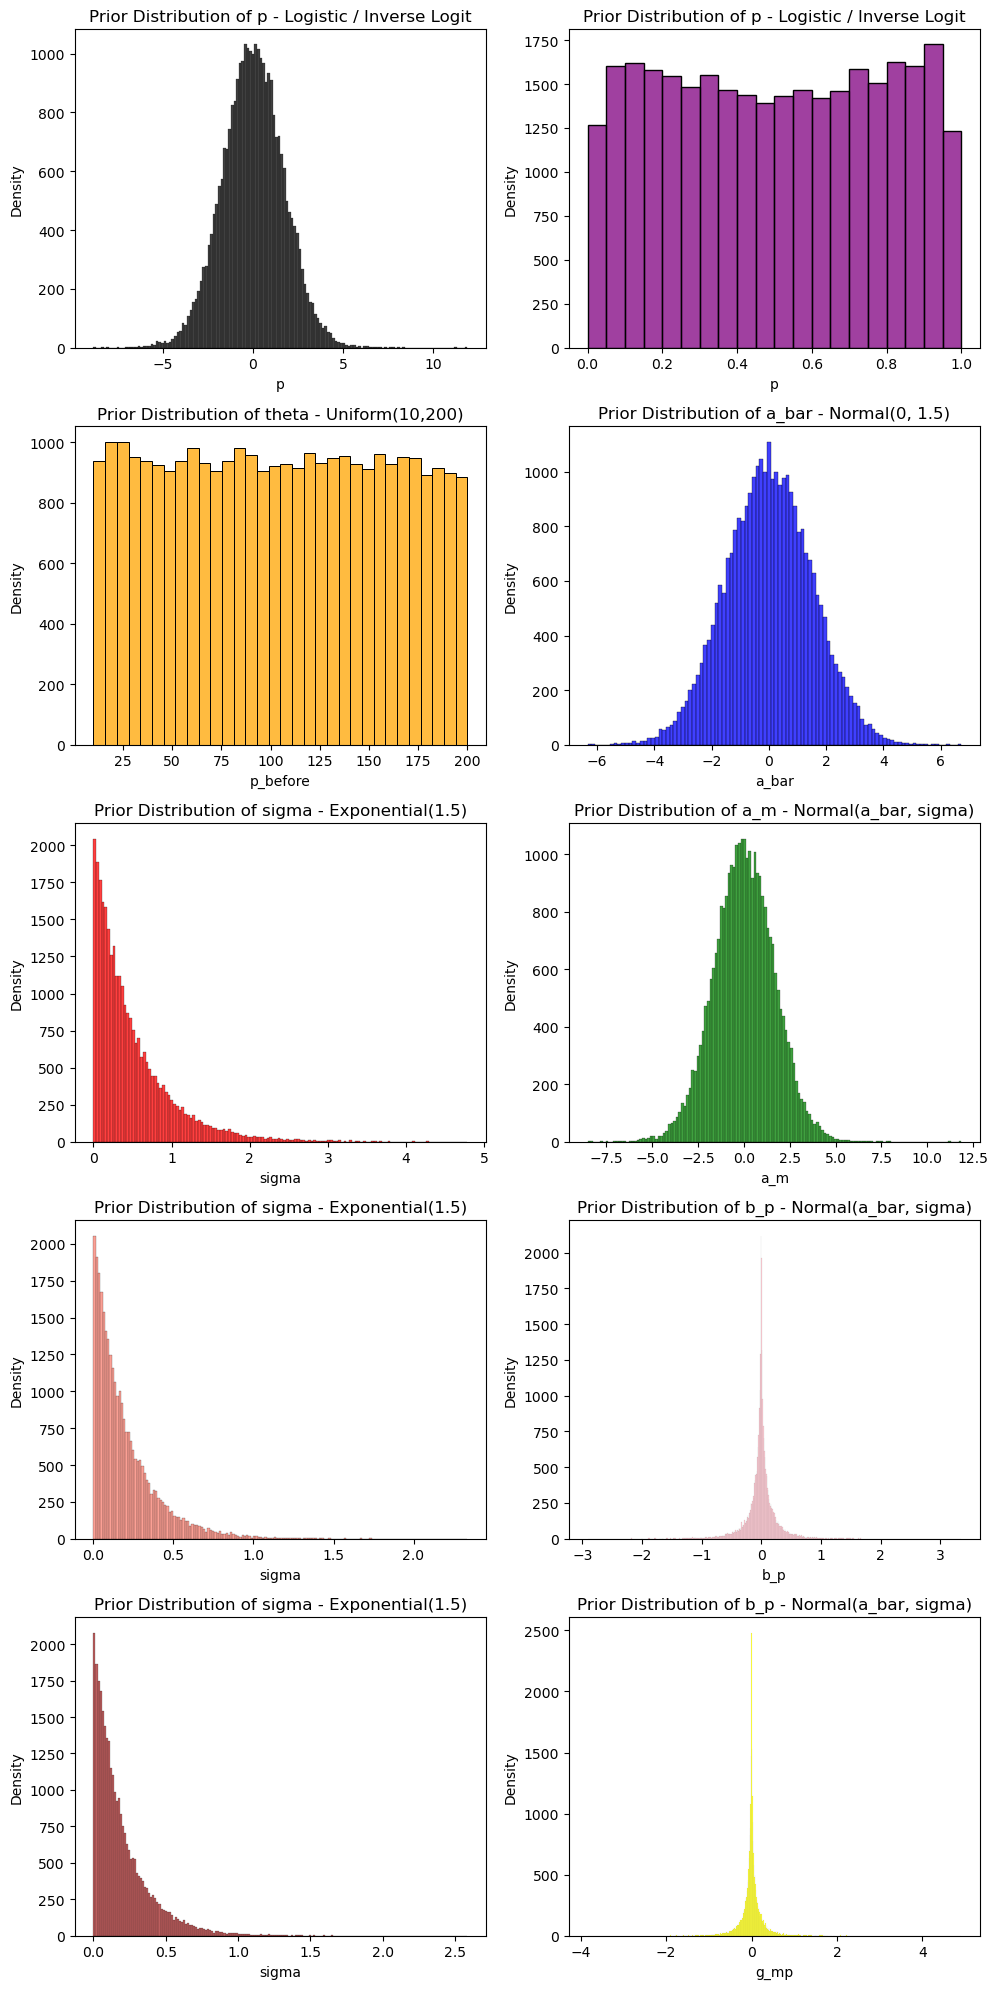

In [6]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma, max_theta):
    with pm.Model() as model:
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Non-centered parameterizations for module, parameter and interaction effect.
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)
        
        pm.Deterministic('p_before', (a_m + b_p + g_mp))

        # Link function (logit), unbounded to (0,1) probability
        pm.Deterministic('p', pm.math.sigmoid(a_m + b_p + g_mp))
        
        # Beta distribution likelihood 
        pm.Uniform('theta', 10, max_theta) # Disperion parameter

        # Sample Priors
        idata = pm.sample_prior_predictive(samples=30000)


    # Fetch and flatten priors
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()


    # Sample one data point from each combination
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    #Predicated observations
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Coverage using priors ', 'Values',
                                        'darkcyan', bin_range=(0, 1.0))
    observation_plot.plot()


    plots = [
        HistogramPlot(idata.prior['p_before'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'black'),
        HistogramPlot(idata.prior['p'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'purple', bin_range=(0, 1), bins=20),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior Distribution of theta - Uniform(10,200)', 'p_before', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of a_bar - Normal(0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior Distribution of a_m - Normal(a_bar, sigma)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))


s_a = FloatSlider(value=2, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
s_b = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
s_g = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
a_bar_mu = FloatSlider(value=0, min=-2, max=2, step=0.1, description='alpha bar mu (a_bar_mu):')
a_bar_sigma = FloatSlider(value=1.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')
max_theta = FloatSlider(value=200, min=20, max=200, step=0.1, description='max bar sigma (a_bar_sigma):')



# Interactive sliders
#interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma, max_theta=max_theta)
calc_prior_dist(2, 5, 5, 0, 1.5, 200)